In [120]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from xgboost import XGBRegressor 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm

In [121]:
# load csv
building = pd.read_csv('../data/preprocessed/Agg_buildings.csv').astype({'datetime': 'datetime64'}) # keep index
# convert datetime column to pd datetime format
building.datetime = pd.to_datetime(building.datetime)
# Extract additional features from timestamp column
building = building.assign(
    timestamp = building['datetime'], # timestamp column is useful for seaborn lineplots
    #date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofweek = lambda x: x['timestamp'].dt.dayofweek,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
    weekofyear = lambda x: x['timestamp'].dt.weekofyear,
)
building.set_index('datetime',inplace=True) # set the datetime column as index column
building.head()

/var/folders/0k/0tj_r1fd1sd9gfvv0qg5bl_m0000gn/T/ipykernel_4265/2242324872.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  weekofyear = lambda x: x['timestamp'].dt.weekofyear,


,daylight_savings,indoor_temp,avg_unmet_cooling_temp,indoor_hum,equipment_electric_power_kW,dhw_heating_kW,cooling_load_kW,solar_generation_W_kW,outdoor_temp,outdoor_hum,...,electric_load_hp_kW,net_load_kW,timestamp,year,month,day,dayofweek,dayofyear,hour,weekofyear
datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-02 00:00:00,0.0,21.516667,0.0,55.982222,81.89,8.76,12.50,NaN,9.40,94.12,...,1.318,91.968,2008-01-02 00:00:00,2008,1,2,2,2,0,1
2008-01-02 01:00:00,0.0,21.528889,0.0,54.130000,58.64,10.08,5.25,NaN,7.61,93.00,...,0.328,69.048,2008-01-02 01:00:00,2008,1,2,2,2,1,1
2008-01-02 02:00:00,0.0,21.581111,0.0,53.107778,62.97,1.56,5.47,NaN,8.11,93.00,...,0.408,64.938,2008-01-02 02:00:00,2008,1,2,2,2,2,1
2008-01-02 03:00:00,0.0,21.437778,0.0,51.641111,61.86,3.96,4.87,NaN,8.36,93.00,...,0.392,66.212,2008-01-02 03:00:00,2008,1,2,2,2,3,1
2008-01-02 04:00:00,0.0,21.425556,0.0,50.933333,59.99,1.56,5.41,NaN,8.78,93.00,...,0.490,62.040,2008-01-02 04:00:00,2008,1,2,2,2,4,1


(14061.0, 14068.0)

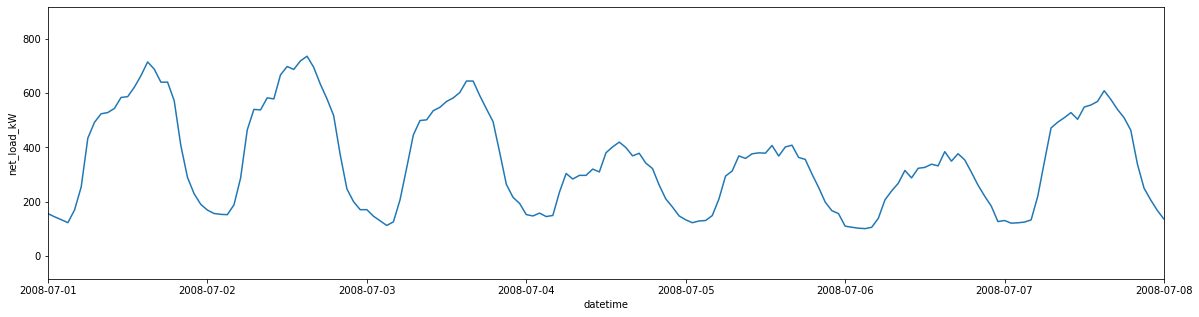

In [122]:
plt.figure(figsize=(20,5))
sns.lineplot(y=building.net_load_kW,x=building.index)
plt.xlim(pd.Timestamp('2008-07-01 00:00:00'),pd.Timestamp('2008-07-08 00:00:00'))

## XGBoost with time features only

In [156]:
# test train split 3 years for training, 4th year for prediction
df_train = building[['net_load_kW']].iloc[:(len(building)-365*24)]
df_test = building[['net_load_kW']].iloc[(len(building)-365*24):]
#df_test.head()

In [5]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df.drop(['date'],axis=1,inplace=True)
    
   # X = df[['hour','dayofweek','quarter','month','year',
   #        'dayofyear','dayofmonth','weekofyear']]
   # if label:
   #     y = df[label]
   #     return X, y
    return df

In [158]:
df_train = create_features(df_train)
df_test= create_features(df_test)
#df_test.head()

/var/folders/0k/0tj_r1fd1sd9gfvv0qg5bl_m0000gn/T/ipykernel_4265/2221054469.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [160]:
y_train = df_train.net_load_kW
X_train = df_train.drop(['net_load_kW'], axis=1)
y_test = df_test.net_load_kW
X_test = df_test.drop(['net_load_kW'], axis=1)
#X_test.head()

In [161]:
xgb_simple = XGBRegressor()
xgb_simple.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [162]:
from sklearn.metrics import mean_squared_error

y_pred_train = xgb_simple.predict(X_train)
y_pred = xgb_simple.predict(X_test)
print('MSE over train data: ',mean_squared_error(y_train,y_pred_train))
print('MSE over test data: ',mean_squared_error(y_test,y_pred))

MSE over train data:  925.2211121655706
MSE over test data:  9276.00455942906


## XGBoost with Lagging the timeseries

In [10]:
df_test.head()

,net_load_kW,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
datetime,,,,,,,,
2011-01-01 00:00:00,12.302,0,5,1,2011,1,1,52
2011-01-01 01:00:00,15.674,1,5,1,2011,1,1,52
2011-01-01 02:00:00,16.200,2,5,1,2011,1,1,52
2011-01-01 03:00:00,19.431,3,5,1,2011,1,1,52
2011-01-01 04:00:00,9.393,4,5,1,2011,1,1,52


In [11]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 25):
    df_train["lag_{}".format(i)] = df_train.net_load_kW.shift(i)
    df_test["lag_{}".format(i)] = df_test.net_load_kW.shift(i)
df_test.tail()

,net_load_kW,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,lag_1,lag_2,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2011-12-31 19:00:00,12.119,19,5,12,2011,365,31,52,14.224,14.966,...,9.125,10.326,11.974,10.870,8.240,10.857,12.793,13.162,16.021,13.561
2011-12-31 20:00:00,14.911,20,5,12,2011,365,31,52,12.119,14.224,...,13.602,9.125,10.326,11.974,10.870,8.240,10.857,12.793,13.162,16.021
2011-12-31 21:00:00,14.352,21,5,12,2011,365,31,52,14.911,12.119,...,15.908,13.602,9.125,10.326,11.974,10.870,8.240,10.857,12.793,13.162
2011-12-31 22:00:00,11.920,22,5,12,2011,365,31,52,14.352,14.911,...,19.556,15.908,13.602,9.125,10.326,11.974,10.870,8.240,10.857,12.793
2011-12-31 23:00:00,11.760,23,5,12,2011,365,31,52,11.920,14.352,...,16.247,19.556,15.908,13.602,9.125,10.326,11.974,10.870,8.240,10.857


In [12]:
y_train = df_train.net_load_kW
X_train = df_train.drop(['net_load_kW'], axis=1)
y_test = df_test.net_load_kW
X_test = df_test.drop(['net_load_kW'], axis=1)
X_train.tail()


,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,lag_1,lag_2,lag_3,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2010-12-31 19:00:00,19,4,12,2010,365,31,52,18.476,25.385,14.362,...,8.950,10.932,6.216,8.444,9.990,15.964,17.445,15.172,17.548,16.604
2010-12-31 20:00:00,20,4,12,2010,365,31,52,20.716,18.476,25.385,...,9.370,8.950,10.932,6.216,8.444,9.990,15.964,17.445,15.172,17.548
2010-12-31 21:00:00,21,4,12,2010,365,31,52,20.128,20.716,18.476,...,23.889,9.370,8.950,10.932,6.216,8.444,9.990,15.964,17.445,15.172
2010-12-31 22:00:00,22,4,12,2010,365,31,52,20.228,20.128,20.716,...,18.186,23.889,9.370,8.950,10.932,6.216,8.444,9.990,15.964,17.445
2010-12-31 23:00:00,23,4,12,2010,365,31,52,24.615,20.228,20.128,...,13.449,18.186,23.889,9.370,8.950,10.932,6.216,8.444,9.990,15.964


In [13]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [14]:
y_pred_train = xgb.predict(X_train)
y_pred = xgb.predict(X_test)
print('MSE over train data: ',mean_squared_error(y_train,y_pred_train))
print('MSE over test data: ',mean_squared_error(y_test,y_pred))

MSE over train data:  12.122790891154269
MSE over test data:  26.946263889427247


## XGD gridsearch

In [131]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

tscv = TimeSeriesSplit(n_splits=5)
# gridsearch for best hyper parameter
# Defining parameter grid (as dictionary)
param_grid = {  "learning_rate"    : [ 0.1, 0.20 ] ,
                'min_child_weight': [2],
                'gamma': [0.5, 1, 1.5],
                'subsample': [0.8, 1.0],
                'colsample_bytree': [1.0],
                'max_depth': [ 4, 5],
                'alpha' : [0,0.5],
                'lambda' : [0,0.5]
            
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(XGBRegressor(), param_grid, scoring='neg_mean_squared_error',
                  cv=tscv, verbose=5, n_jobs=-1);

# Fit gridsearch object to data
gs.fit(X_train, y_train);


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END alpha=0, colsample_bytree=1.0, gamma=0.5, lambda=0, learning_rate=0.1, max_depth=4, min_child_weight=2, subsample=0.8;, score=-1380.156 total time=   2.6s
[CV 1/5] END alpha=0, colsample_bytree=1.0, gamma=0.5, lambda=0, learning_rate=0.1, max_depth=4, min_child_weight=2, subsample=1.0;, score=-1415.197 total time=   3.0s
[CV 2/5] END alpha=0, colsample_bytree=1.0, gamma=0.5, lambda=0, learning_rate=0.1, max_depth=4, min_child_weight=2, subsample=0.8;, score=-593.907 total time=   5.3s
[CV 2/5] END alpha=0, colsample_bytree=1.0, gamma=0.5, lambda=0, learning_rate=0.1, max_depth=4, min_child_weight=2, subsample=1.0;, score=-586.288 total time=   6.1s
[CV 3/5] END alpha=0, colsample_bytree=1.0, gamma=0.5, lambda=0, learning_rate=0.1, max_depth=4, min_child_weight=2, subsample=1.0;, score=-1064.296 total time=   8.7s
[CV 3/5] END alpha=0, colsample_bytree=1.0, gamma=0.5, lambda=0, learning_rate=0.1, max_depth=4, min

In [132]:
# Best parameters
print('Best parameters:', gs.best_params_)
# Assigning the fitted 
xgb_best = gs.best_estimator_


Best parameters: {'alpha': 0.5, 'colsample_bytree': 1.0, 'gamma': 0.5, 'lambda': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 1.0}


In [133]:
# Making predictions on the test set with best parameters
y_pred_train = xgb_best.predict(X_train)
y_pred = xgb_best.predict(X_test)
print('MSE over train data: ',mean_squared_error(y_train,y_pred_train))
print('MSE over test data: ',mean_squared_error(y_test,y_pred))

MSE over train data:  307.8169998889408
MSE over test data:  2293.3643429845897


Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 1.0}

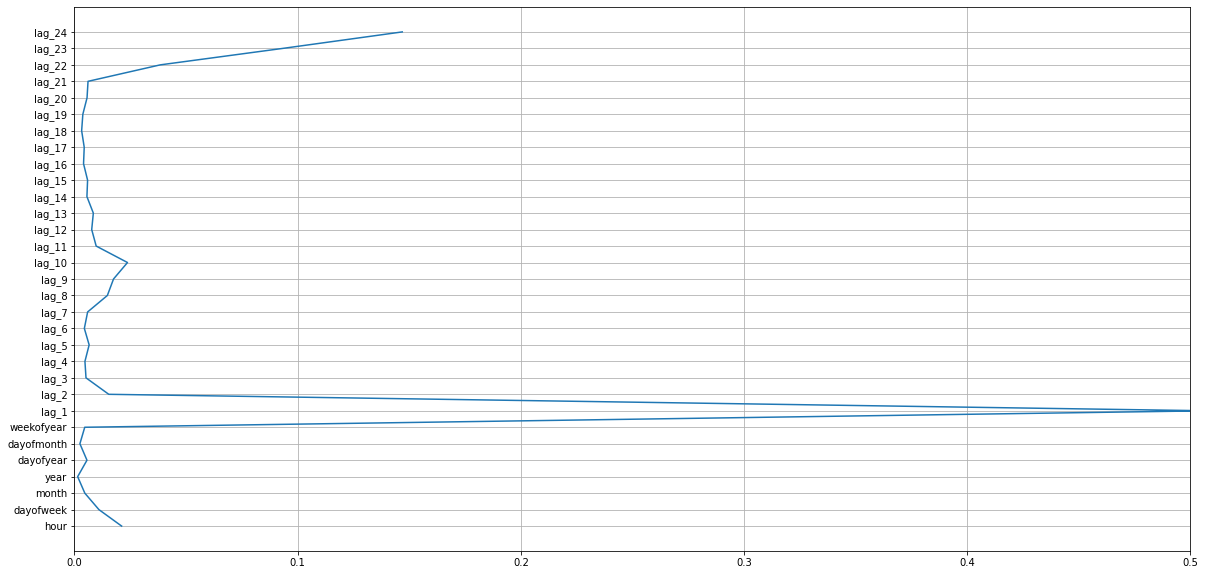

In [128]:
#feature importance
fig, ax=plt.subplots(figsize=(20,10))
plt.plot(xgb_best.feature_importances_, X_train.columns)
plt.xlim(0,0.5)
plt.grid('major')

## Add one week lookback with best parameters

/Users/leee/neuefische/TheGreenCitySolutionsGroup/.venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


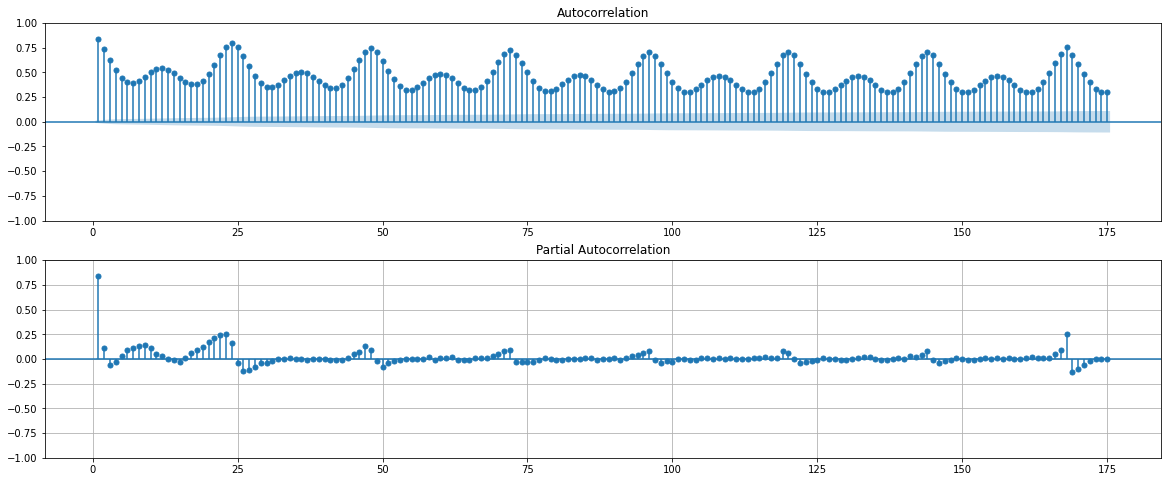

In [120]:
# autocorrelation
fig, ax = plt.subplots(2,1, figsize=(20,8))
fig = sm.graphics.tsa.plot_acf(y_train, lags=7*25, zero=False, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_train, lags=7*25, zero=False, ax=ax[1])
plt.grid('minor')
plt.show()

In [163]:
# data frame with weather
# extract dataframe from main dataframe, using predicted weather features for the test dataframe
df_train_w = building[['net_load_kW','outdoor_temp','outdoor_hum','diffuse_solar_W_m2','direct_solar_W_m2','year', 'month', 'day', 'dayofweek', 'dayofyear', 'hour',
       'weekofyear']].iloc[:(len(building)-365*24)]
df_test_w = building[['net_load_kW','pred_24h_outdoor_temp','pred_24h_outdoor_hum','pred_24h_diffuse_solar_W_m2','pred_24h_direct_solar_W_m2','year', 'month', 'day', 'dayofweek', 'dayofyear', 'hour',
       'weekofyear']].iloc[(len(building)-365*24):]  


In [ ]:
# label encoder when using holiday workday feature (not improving)
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
#df_train_w['holiday'] = label_enc.fit_transform(df_train_w['holiday']) 
#df_test_w['holiday'] = label_enc.transform(df_test_w['holiday'])   
#df_train_w['workday'] = label_enc.fit_transform(df_train_w['workday']) 
#df_test_w['workday'] = label_enc.transform(df_test_w['workday'])    
df_test_w.head(30)

In [164]:
# shift weather data  24 hours for prediction
df_test_w.pred_24h_diffuse_solar_W_m2 = df_test_w.pred_24h_diffuse_solar_W_m2.shift(24)
df_test_w.pred_24h_direct_solar_W_m2 = df_test_w.pred_24h_direct_solar_W_m2.shift(24)
df_test_w.pred_24h_outdoor_hum = df_test_w.pred_24h_outdoor_hum.shift(24)
df_test_w.pred_24h_outdoor_temp = df_test_w.pred_24h_outdoor_temp.shift(24)
#df_test_w.head()

In [165]:
# Adding the lag of the target variable from 1 steps back up to 25 + 168 +169 hours
for i in range(1, 26):
    df_train_w["lag_{}".format(i)] = df_train.net_load_kW.shift(i)
    df_test_w["lag_{}".format(i)] = df_test.net_load_kW.shift(i)
# add time lag of one week (168 hours) and 169 hours
df_train_w["lag_{}".format(24*7)] = df_train.net_load_kW.shift(24*7)
df_test_w["lag_{}".format(24*7)] = df_test.net_load_kW.shift(24*7)  
df_train_w["lag_{}".format(24*7+1)] = df_train.net_load_kW.shift(24*7+1)
df_test_w["lag_{}".format(24*7+1)] = df_test.net_load_kW.shift(24*7+1)     
#df_test_w.tail()

In [166]:
# create target and features on train and test data
y_train = df_train_w.net_load_kW
X_train = df_train_w.drop(['net_load_kW'], axis=1)
y_test = df_test_w.net_load_kW
X_test = df_test_w.drop(['net_load_kW'], axis=1)
#X_train.tail()

In [199]:
# best parameters from gridsearch
#xgb_parameters = {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 1.0}
xgb_best = XGBRegressor(colsample_bytree = 1.0,
                        gamma = 0.5,
                        learning_rate= 0.2,
                        max_depth= 5,
                        min_child_weight=2,
                        subsample= 1.0
                        )
xgb_best.fit(X_train,y_train)

XGBRegressor(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=2,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.5, ...)

In [200]:
# Making predictions on the test set with best parameters
y_pred_train = xgb_best.predict(X_train)
y_pred = xgb_best.predict(X_test)
print('MSE over train data: ',mean_squared_error(y_train,y_pred_train))
print('MSE over test data: ',mean_squared_error(y_test,y_pred))

MSE over train data:  233.1764837905959
MSE over test data:  673.1638884884961


For all buildings:
MSE over train data:  317.7117082641055
MSE over test data:  2303.7184522496177

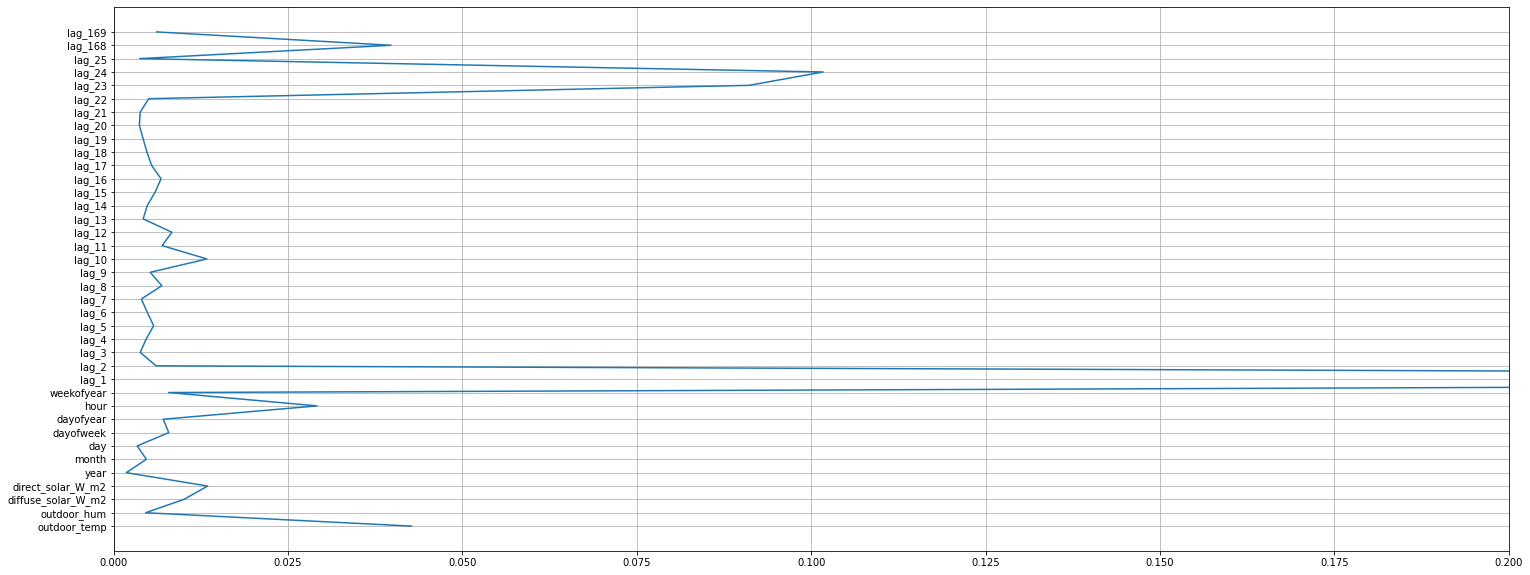

In [140]:
#feature importance
fig, ax=plt.subplots(figsize=(25,10))
plt.plot(xgb.feature_importances_, X_train.columns)
plt.xlim(0,0.2)
plt.grid('major')

## Predict 8 test days

In [201]:
## MLFLOW ##
import mlflow
from green_city.mlflow_config import get_mlflow_config

flow_conf = get_mlflow_config()
tracking_uri = flow_conf["TRACKING_URI"]
mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);

In [152]:
## DB CONNECTION ##
from sqlalchemy import create_engine
from decouple import Config, RepositoryEnv

config = Config(RepositoryEnv("../.db_credentials"))

db_connection_credentials = {
    "database": config('POSTGRES_DB'),
    "user": config('POSTGRES_USER'),
    "password": config('POSTGRES_PASSWORD'),
    "host": config('POSTGRES_HOST'),
    "port": config('POSTGRES_PORT'),
}
DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
db = create_engine(DB_STRING)

In [202]:
days_to_forecast = pd.to_datetime(['2011-09-01 23:00:00', '2011-10-20 23:00:00', 
                                   '2011-01-09 06:00:00', '2011-10-22 21:00:00', 
                                   '2011-06-21 03:00:00', '2011-07-08 02:00:00', 
                                   '2011-08-19 00:00:00', '2011-04-15 07:00:00'])

In [206]:
xgb_best = XGBRegressor(colsample_bytree = 1.0,
                        gamma = 0.5,
                        learning_rate= 0.2,
                        max_depth= 5,
                        min_child_weight=2,
                        subsample= 1.0
                        )

In [205]:
from pandas.tseries.offsets import DateOffset
from green_city.utils import metrics_dict, datetime2index, index2datetime

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "feature": "net_load_kWh",
    "building_nr": 'all',
    "resolution": "H",
    "pred_steps": 24,
}

predictions = list()
for day in days_to_forecast:
     params = global_params.copy()
     params.update({
               "index": datetime2index(pd.Timestamp(day)),
               "datetime": pd.Timestamp(day),
               #"index": index,
               #"datetime": index2datetime(index),
               #"pred_steps": 24,
               #"train_steps": day,
               "model": "XGBoost",
               #"seasonalities": [24],
        })

     y_to_train = building['net_load_kW'].loc[building.index <= day]
     X_to_train = building[['outdoor_temp','outdoor_hum','diffuse_solar_W_m2','direct_solar_W_m2','year', 'month', 'day', 'dayofweek', 'dayofyear', 'hour',
          'weekofyear']].loc[building.index <= day]
     y_to_test = building['net_load_kW'].loc[(building.index > day) & (building.index <= (day + pd.DateOffset(days=1)))]
     X_to_test = building[['outdoor_temp','outdoor_hum','diffuse_solar_W_m2','direct_solar_W_m2','year', 'month', 'day', 'dayofweek', 'dayofyear', 'hour',
          'weekofyear']].loc[(building.index > day) & (building.index <= (day + pd.DateOffset(days=1)))]
     #print(X_to_test)
     xgb_best.fit(X_to_train, y_to_train)
     output = xgb_best.predict(X_to_test)
     output = pd.DataFrame(output,index=X_to_test.index)
     output['y_to_test'] = y_to_test
     predictions.append(output)

     with mlflow.start_run(run_name=f"XGB_optimized") as r:
          metrics = metrics_dict(output.y_to_test, output[0], ["mae", "mse", "r2_score"])
          print("mae: {mae}, mse: {mse}, r2: {r2_score}".format(**metrics))
          mlflow.log_metrics(metrics)

          ## logging ##
          mlflow.log_params(params)
          ## save result to database ##
          #needs to be a table with ["id", "prediction", "run_id"] as columns (which can include the index-column)
          forecasts = output[[0]].assign(run_id = r.info.run_id).rename(columns={0: "prediction"})
          forecasts.index.name = 'id'
          forecasts.index = datetime2index(forecasts.index)
          #forecasts.to_sql("forecast", con=db, if_exists="append")
  

mae: 22.578181587219245, mse: 850.8417297838297, r2: 0.9581020036949773
mae: 22.055588523864742, mse: 894.5440014965942, r2: 0.9425494658472038
mae: 22.023848564147954, mse: 916.797524746887, r2: 0.5208108576983708
mae: 13.526149607340495, mse: 248.0565825987787, r2: 0.9130131995433871
mae: 17.392031267801922, mse: 436.7589964866147, r2: 0.9807555595984282
mae: 26.891493606567384, mse: 1217.4213350696316, r2: 0.9438479529665045
mae: 29.0205247853597, mse: 1404.52281870516, r2: 0.9670288278935496
mae: 25.4341750310262, mse: 1059.7077564558454, r2: 0.822501010793061
